# Econometrics-3:
# GMM, QML, Score-test, HAC


## Load libraries

In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## 0. And still, why does the sandwich collapse?

Consider a linear regression with one regressor:
$$ y = \beta x + e, \quad E[e|x]=0, \quad E\left[e^2|x\right] = \sigma^2(x) $$

Let $\{(x_i, y_i)\}_{i=1}^n$ be i.i.d. Suppose we seek for the best weighted least squares estimator with a diagonal weight matrix:
$$ \hat{\beta} = (X'WX)^{-1} X'WY = \frac{\sum_{i=1}^n w_i x_i y_i}{\sum_{i=1}^{n} w_i x_i^2} $$

Conditional variance:
$$ V_\beta = \text{Var}[\hat{\beta}|X] = \frac{\sum_{i=1}^{n} w_i^2 x_i^2 \sigma^2(x_i)}{\left(\sum_{i=1}^n w_i x_i^2\right)^2} $$

(Notice two slices of delicious bread in the denominator.)

Let's choose the optimal weights in terms of minimizing $V_\beta$ (you have already known the answer: $w_i = 1/\sigma^2(x_i)$). Define $w_i = \alpha_i / \sigma^2(x_i)$. Then:
$$ V_\beta = \frac{\sum_{i=1}^{n} \alpha_i^2 x_i^2 / \sigma^2(x_i)}{\left(\sum_{i=1}^n \alpha_i x_i^2 / \sigma^2(x_i)\right)^2} \to \min\limits_{\{\alpha_i\}} $$

Can you draw an analogy with $\dfrac{E[\xi^2]}{(E[\xi])^2}$?

Define the following probability space $(\Omega^*, \mathcal{F}^*, P^*)$:
$$ \Omega^* = \{ 1, \ldots, n \}, \quad \mathcal{F}^* = 2^{\Omega^*}, \quad P^*(\{i\}) = \frac{x_i^2/\sigma^2(x_i)}{S}, \quad \text{where } S = \sum_{j=1}^n x_j^2 / \sigma^2(x_j) $$

Then $\alpha$ is a random variable, and $V_\beta = S^{-1} \dfrac{E^*[\alpha^2]}{\left(E^*[\alpha]\right)^2} = S^{-1} \left( 1 + \dfrac{\text{Var}^*[\alpha]}{\left(E^*[\alpha]\right)^2} \right) \to \min\limits_\alpha $

So, $\alpha$ should be constant (for example, $\alpha = 1$), then $\text{Var}^*[\alpha] = 0$. In other words, $\alpha^2$ (in "buttery" numerator) should be proportional to $\alpha$ (in "bready" denominator). That is to say, sandwich collapses :)

## 1. The wisdom of GMM

Recall Problemnik 12.2 from section 5:
$$ m(x, y, q) = \begin{pmatrix} x - q \\ y \end{pmatrix}, \quad E[m(x,y,\theta)] = 0 $$

We could estimate $\theta = E[x]$ as usual:
$$ \hat{\theta}_{CMM} = \bar{x}, \quad \sqrt{n}(\hat{\theta}_{CMM} - \theta) \mathop{\to}^{d} \mathcal{N}(0, \text{Var}[x]) $$

Alternatively, we can apply GMM:
$$ \hat{\theta}_{GMM} = \arg \min_{q} \bar{m}' \hat{V}_m^{-1} \bar{m}, \quad V_m = E[mm'] = \begin{pmatrix} \text{Var}[x] & \text{Cov}[x,y] \\ \text{Cov}[x,y] & \text{Var}[y] \end{pmatrix}, \quad \sqrt{n}(\hat{\theta}_{GMM} - \theta) \mathop{\to}^{d} \mathcal{N}\left(0, \text{Var}[x] - \frac{(\text{Cov}[x,y])^2}{\text{Var}[y]}\right) $$

Obviously, GMM is better than CMM if and only if $x$ and $y$ are correlated.

Let's estimate $V_m$ casually:
$$ \hat{V}_m = \begin{pmatrix} \widehat{\text{Var}[x]} & \widehat{\text{Cov}[x,y]} \\ \widehat{\text{Cov}[x,y]} & \widehat{\text{Var}[y]} \end{pmatrix} = \begin{pmatrix} \overline{x^2} - \bar{x}^2 & \overline{xy} - \bar{x} \bar{y} \\ \overline{xy} - \bar{x} \bar{y} & \overline{y^2} - \bar{y}^2 \end{pmatrix} $$

You can easily show that $\hat{\theta}_{GMM} = \bar{x} - \dfrac{\widehat{\text{Cov}[x, y]}}{\widehat{\text{Var}[y]}} \bar{y}$.

For instance, suppose that $x$ and $y$ are positively correlated. Then positive $\bar{y}$ is an evidence of positive error $(\bar{x} - \theta)$. So, it would be nice to subtract something from $\bar{x}$. And vice versa.

Actually, the GMM reasoning is even more sophisticated.

To reduce an error $(\bar{x} - \theta)$, an econometrician could make an effort to establish a link between $x$ and $y$ by running OLS:
$$ \text{BLP}[x|y] = \beta_0 + \beta_1 y \quad\text{(not exactly $E[x|y]$)}, \quad \beta_1 = \frac{\text{Cov}[x, y]}{\text{Var}[y]}, \quad \beta_0 = E[x] - \beta_1 E[y] $$

After that, the econometrician can suppress noise significantly by setting $y = 0$:
$$ \hat{\theta} = \widehat{\text{BLP}}[x|y=0] = \bar{x} - \frac{\widehat{\text{Cov}[x, y]}}{\widehat{\text{Var}[y]}} \bar{y} = \hat{\theta}_{GMM} $$

And for the grand finale, visualization!

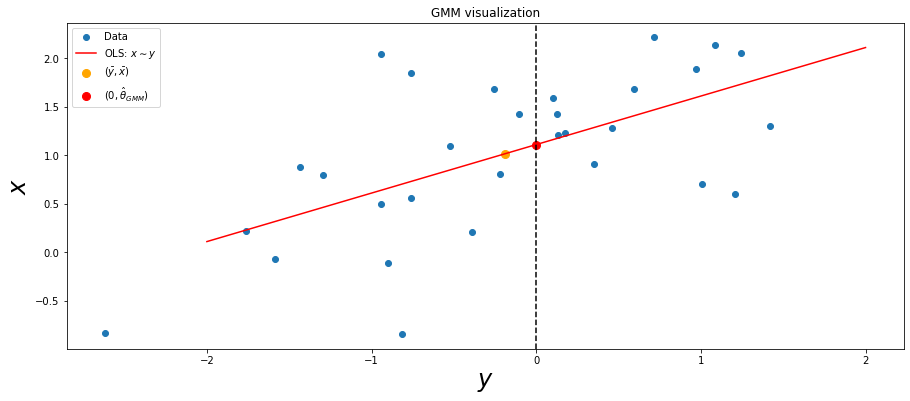

In [ ]:
n = 30
theta = 1
y, x = scipy.stats.multivariate_normal.rvs(mean=[0, theta], cov=[[1, 0.7], [0.7, 1]], size=n).T
Y = np.array([np.ones(n), y]).T
beta0_hat, beta1_hat = np.linalg.inv(Y.T @ Y) @ (Y.T @ x)
theta_gmm = np.mean(x) - np.mean(y) * (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(y ** 2) - np.mean(y) ** 2)
plt.figure(figsize=(15, 6))
plt.scatter(y, x, label='Data')
plt.xlabel('$y$', fontsize=24)
plt.ylabel('$x$', fontsize=24)
grid = np.array([-2, 2])
plt.plot(grid, beta0_hat + beta1_hat * grid, color='red', label='OLS: $x \sim y$')
plt.title('GMM visualization')
plt.scatter(np.mean(y), np.mean(x), color='orange', s=64, label='$(\\bar{y}, \\bar{x})$')
plt.scatter(0, theta_gmm, color='red', s=64, label='$(0, \\hat{\\theta}_{GMM})$')
plt.axvline(0, color='black', linestyle='dashed')
plt.legend()
plt.show()

## 2. Guessing about the likelihood

Recall Home Assignment 4, problem 2 "Publish or perish":
$$ P[M=m|x] = \frac{e^{-\lambda(x|\alpha,\beta)}\lambda(x|\alpha,\beta)^m}{m!}, \quad \text{where } \lambda(x|\alpha, \beta) = e^{\alpha+\beta x} $$

Here $M$ is the number of papers the economist published in 2021, $x$ is the number of years since obtaining PhD.

Score function:
$$ s(x,M,a,b) = \begin{pmatrix} M - e^{a + b x} \\ x (M - e^{a + b x}) \end{pmatrix}, \quad E[s(x, M, \alpha, \beta)] = 0 $$

Maximum likelihood estimator:
$$ \begin{cases}
\overline{M} - e^{\hat{\alpha}} \overline{e^{\hat{\beta} x}} = 0 \\
\overline{xM} - e^{\hat{\alpha}} \overline{x e^{\hat{\beta}x}} = 0
\end{cases} \quad\Longrightarrow\quad \hat{\alpha} = \ldots, \, \hat{\beta} = \ldots $$

Under $H_0: \beta = 0$ (publishing a paper is pure luck):
$$ \hat{\alpha}_0 = \ln \overline{M} $$

How to test $H_0$ against $H_1: \beta \neq 0$?
* Wald test
* Likelihood ratio test
* Score test

We can't find $\hat{\alpha}$ and $\hat{\beta}$ analytically. So, the Score-test is the only option:
$$ \mathcal{LM} = n \bar{s}(\hat{\alpha}_0, \hat{\beta}_0)' I(\hat{\alpha}_0, \hat{\beta}_0)^{-1} \bar{s}(\hat{\alpha}_0, \hat{\beta}_0) = n \left(\overline{xM} - \bar{x} \overline{M}\right)^2 \left(I(\hat{\alpha}_0)^{-1}\right)_{22} \mathop{\to}^{d} \chi^2(1) \quad\text{under $H_0$} $$

How to calculate $I(\hat{\alpha}_0, \hat{\beta}_0)$?
* $I = -E\left[ \dfrac{\partial s}{\partial \theta'} \right]$
* $I = E[ss']$

The first approach is easier:
$$ \hat{I}(\hat{\alpha}_0, \hat{\beta}_0) = \left.-\hat{E} \left[ \begin{pmatrix} -e^{a + b x} & -x e^{a + b x} \\ -x e^{a + b x} & -x^2 e^{a + b x} \end{pmatrix} \right]\right|_{a=\overline{M}, \, b = 0} = \overline{M} \begin{pmatrix} 1 & \bar{x} \\ \bar{x} & \overline{x^2} \end{pmatrix} $$
$$ \hat{I}(\hat{\alpha}_0, \hat{\beta}_0)^{-1} = \frac{1}{\overline{M}\left(\overline{x^2} - \bar{x}^2\right)} \begin{pmatrix} \overline{x^2} & -\bar{x} \\ -\bar{x} & 1 \end{pmatrix} $$
$$ \mathcal{LM} = \frac{n \left(\overline{xM} - \bar{x} \overline{M}\right)^2}{\overline{M}\left(\overline{x^2} - \bar{x}^2\right)} $$

$H_0$ is rejected if $\mathcal{LM} > \chi^2_{0.95}(1)$.

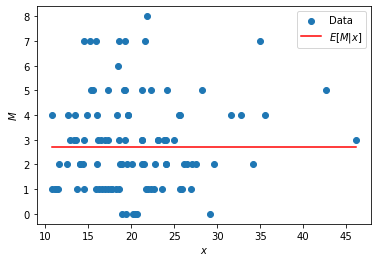

In [ ]:
alpha = 1
beta = 0
n = 100
x = scipy.stats.gamma.rvs(a=10, scale=2, size=n)
lam = np.exp(alpha + beta * x)
M = scipy.stats.poisson.rvs(mu=lam)
plt.scatter(x, M, label='Data')
grid = np.linspace(np.min(x), np.max(x), 101)
plt.plot(grid, np.exp(alpha + beta * grid), color='red', label='$E[M|x]$')
plt.xlabel('$x$')
plt.ylabel('$M$')
plt.legend()
plt.show()

In [ ]:
N_exp = 10000
x = scipy.stats.gamma.rvs(a=10, scale=2, size=(N_exp, n))
lam = np.exp(alpha + beta * x)
M = scipy.stats.poisson.rvs(mu=lam)
LM = n * (np.mean(x * M, axis=1) - np.mean(x, axis=1) * np.mean(M, axis=1)) ** 2 / np.mean(M, axis=1) / (np.mean(x ** 2, axis=1) - np.mean(x, axis=1) ** 2)
print(f'H0 is rejected in {np.mean(LM > scipy.stats.chi2.ppf(0.95, df=1)) * 100:.2f}% cases')

H0 is rejected in 4.82% cases


But what if the formula for $P[M=m|x]$ is wrong? Suppose all we have is the following nonlinear regression: (Do not hurry to apply NLLS!)
$$ E[M|x] = \lambda(x|\alpha, \beta) = e^{\alpha + \beta x} $$

Then ML becomes QML, and the score function becomes the moment function in CMM:
$$ s(x,M,a,b) = \begin{pmatrix} M - e^{a + b x} \\ x (M - e^{a + b x}) \end{pmatrix}, \quad E[s(x, M, \alpha, \beta)] = 0 $$

However, our test (reject $H_0$ if $\mathcal{LM} > \chi^2_{0.95}(1)$) is not correct anymore:

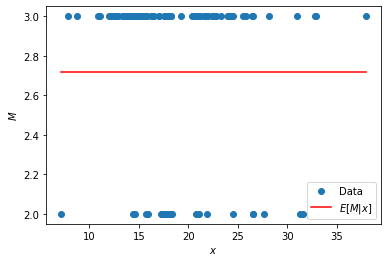

In [ ]:
alpha = 1
beta = 0
n = 100
x = scipy.stats.gamma.rvs(a=10, scale=2, size=n)
lam = np.exp(alpha + beta * x)
M = np.floor(lam) + scipy.stats.bernoulli.rvs(p=lam - np.floor(lam))
plt.scatter(x, M, label='Data')
grid = np.linspace(np.min(x), np.max(x), 101)
plt.plot(grid, np.exp(alpha + beta * grid), color='red', label='$E[M|x]$')
plt.xlabel('$x$')
plt.ylabel('$M$')
plt.legend()
plt.show()

In [ ]:
N_exp = 10000
x = scipy.stats.gamma.rvs(a=10, scale=2, size=(N_exp, n))
lam = np.exp(alpha + beta * x)
M = np.floor(lam) + scipy.stats.bernoulli.rvs(p=lam - np.floor(lam))
LM = n * (np.mean(x * M, axis=1) - np.mean(x, axis=1) * np.mean(M, axis=1)) ** 2 / np.mean(M, axis=1) / (np.mean(x ** 2, axis=1) - np.mean(x, axis=1) ** 2)
print(f'H0 is rejected in {np.mean(LM > scipy.stats.chi2.ppf(0.95, df=1)) * 100:.2f}% cases')

H0 is rejected in 0.00% cases


Note that $I = E[ss']$ is in line with CMM and DD-test, so it is more robust. If we reestimate $I(\hat{\alpha}_0, \hat{\beta}_0)$ then our "Score-test" becomes correct again:

In [ ]:
s = np.array([M - np.mean(M, axis=1)[:, np.newaxis], x * (M - np.mean(M, axis=1)[:, np.newaxis])]).transpose(1, 2, 0)
I = np.mean(s[:, :, :, np.newaxis] @ s[:, :, np.newaxis, :], axis=1)
s_mean = np.mean(s, axis=1)
LM = n * (s_mean[:, np.newaxis, :] @ np.linalg.inv(I) @ s_mean[:, :, np.newaxis])[:, 0, 0]
print(f'H0 is rejected in {np.mean(LM > scipy.stats.chi2.ppf(0.95, df=1)) * 100:.2f}% cases')

H0 is rejected in 5.59% cases


## 3. Robustness of HAC

*(Actually, today we are going to talk about long-run variance in general, not about HAC itself.)*

### 3.1 Conditional unbiasedness of spot rates

Recall Home Assignment 3, problem 2 "Testing for forecast unbiasedness":

$$ s_{t+k} - s_{t} = \alpha + \beta (f_{t,k} - s_t) + e_{t+k}, \quad E_t[e_{t+k}] = 0, $$

where $s_t$ is the spot rate, $f_{t,k}$ is the forward rate for $k$-month forwards, $k \in \{1, 3\}$.

OLS in a matrix form:
$$ \begin{pmatrix} \hat{\alpha} \\ \hat{\beta} \end{pmatrix} = (X'X)^{-1} X'Y, \quad X = \begin{pmatrix} 1 & f_{1,k} - s_1 \\ \cdots & \cdots \\ 1 & f_{T-k,k} - s_{T-k} \end{pmatrix}, \quad Y = \begin{pmatrix} s_{1+k} - s_{1} \\ \cdots \\ s_{T} - s_{T-k} \end{pmatrix}, \quad \varepsilon = \begin{pmatrix} e_{1+k} \\ \cdots \\ e_{T} \end{pmatrix} $$

CLT+LLN for time series:
$$ \sqrt{T - k} \left( \begin{pmatrix} \hat{\alpha} \\ \hat{\beta} \end{pmatrix} - \begin{pmatrix} \alpha \\ \beta \end{pmatrix} \right) = \sqrt{T-k} (X'X)^{-1} X' \varepsilon = {\underbrace{\left(\frac{1}{T-k} \sum_{t=1}^{T-k} x_t x_t'\right)}_{\mathop{\to}\limits^{P} E[x_t x_t'] = Q_{xx} \text{ (LLN)}}}^{-1} \underbrace{\left(\frac{1}{\sqrt{T-k}} \sum_{t=1}^{T-k} x_t e_{t+k} \right)}_{\mathop{\to}\limits^{d} \mathcal{N}(0, V_{xe}) \text{ (CLT)}} \mathop{\to}^{d} \mathcal{N}(0, Q_{xx}^{-1} V_{xe} Q_{xx}^{-1}), $$

where $V_{xe}$ is long-run variance:
$$ V_{xe} = \sum_{j=-\infty}^{+\infty} \underbrace{\text{Cov}[x_t e_{t+k}, x_{t-j} e_{t-j+k}]}_{\Gamma_j} $$

For $j \ge k$: $\quad \Gamma_j = E[x_t x_{t-j}' e_{t+k} e_{t-j+k}] = E[E_t[x_t x_{t-j}' e_{t+k} e_{t-j+k}]] = E[x_t x_{t-j}' e_{t-j+k} \underbrace{E_t[e_{t+k}]}_{0}] = 0, \quad \Gamma_{-j} = \Gamma_j' = 0$.
$$ \Longrightarrow\quad V_{xe} = \sum_{j=-(k-1)}^{k-1} \Gamma_j = \begin{cases}
\Gamma_0, \quad&\text{if } k = 1, \\
\Gamma_{-2} + \Gamma_{-1} + \Gamma_{0} + \Gamma_{1} + \Gamma_{2}, \quad&\text{if } k = 3.
\end{cases} $$

### 3.2 Understanding long-run variance

#### 3.2.1 Making errors

Consider the following autoregressive model equation:
$$ u_t = \rho u_{t-1} + e_t, \quad |\rho| < 1, \quad \text{$\{e_t\}$ is strong white noise}, \quad e_t \sim \mathcal{N}(0, \sigma_e^2), \quad E_{t-1}[e_t] = 0 $$

For now, let's set $u_1$ arbitrarily:

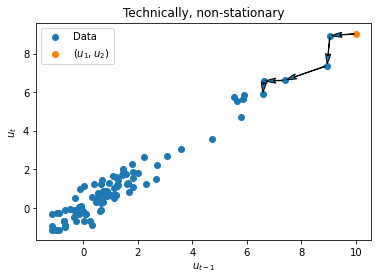

In [ ]:
rho = 0.9
sigma_u = 1
T = 100
u = [10]
eps = scipy.stats.norm.rvs(loc=0, scale=sigma_u * np.sqrt(1 - rho ** 2), size=T - 1)
for t in range(T - 1):
    u.append(rho * u[-1] + eps[t])
fig, ax = plt.subplots() 
ax.scatter(u[1:-1], u[2:], label='Data')
ax.scatter(u[0], u[1], label='$(u_1, u_2)$')
arrowstyle = mpatches.ArrowStyle('Fancy', head_length=10, head_width=5, tail_width=0.5)
for t in range(5):
    ax.add_patch(mpatches.FancyArrowPatch((u[t], u[t + 1]), (u[t + 1], u[t + 2]), arrowstyle=arrowstyle))
ax.set_title('Technically, non-stationary')
ax.set_xlabel('$u_{t-1}$')
ax.set_ylabel('$u_t$')
ax.legend()
plt.show()

Stationarity comes gradually here. To make $\{ u_t \}_{t=1}^T$ truly stationary, we should adjust $u_1$ accordingly:
$$ u_t = \rho u_{t-1} + e_t = \ldots = \underbrace{\rho^j}_{\to 0} u_{t-j} + \underbrace{\sum_{k=0}^{j-1} \rho^k e_{t-k}}_{\mathop{\to}\limits^{d} \mathcal{N}\left(0, \frac{\sigma_e^2}{1-\rho^2} \right)} $$

The only way to make $\{ u_t \}_{t=1}^T$ stationary is to set $u_1 \sim \mathcal{N}\left(0, \frac{\sigma_e^2}{1-\rho^2} \right)$:

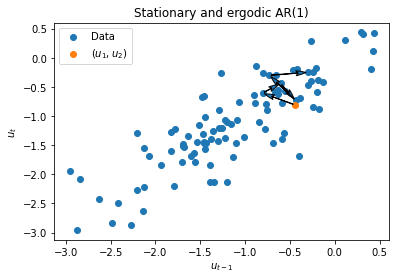

In [ ]:
rho = 0.9
sigma_u = 1
T = 100
u = [scipy.stats.norm.rvs(loc=0, scale=sigma_u)]
eps = scipy.stats.norm.rvs(loc=0, scale=sigma_u * np.sqrt(1 - rho ** 2), size=T - 1)
for t in range(T - 1):
    u.append(rho * u[-1] + eps[t])
fig, ax = plt.subplots() 
ax.scatter(u[1:-1], u[2:], label='Data')
ax.scatter(u[0], u[1], label='$(u_1, u_2)$')
arrowstyle = mpatches.ArrowStyle('Fancy', head_length=10, head_width=5, tail_width=0.5)
for t in range(5):
    ax.add_patch(mpatches.FancyArrowPatch((u[t], u[t + 1]), (u[t + 1], u[t + 2]), arrowstyle=arrowstyle))
ax.set_title('Stationary and ergodic AR(1)')
ax.set_xlabel('$u_{t-1}$')
ax.set_ylabel('$u_t$')
ax.legend()
plt.show()

OLS estimator for $\rho$:
$$ \hat{\rho} = (X'X)^{-1} X'Y, \quad X = \begin{pmatrix} u_1 \\ \cdots \\ u_{T-1} \end{pmatrix}, \quad Y = \begin{pmatrix} u_2 \\ \cdots \\ u_{T} \end{pmatrix}, \quad \varepsilon = \begin{pmatrix} e_2 \\ \cdots \\ e_{T} \end{pmatrix} $$
CLT+LLN for time series:
$$ \sqrt{T-1}(\hat{\rho}-\rho) = \sqrt{T-1} (X'X)^{-1} X' \varepsilon = {\underbrace{\left(\frac{1}{T-1} \sum_{t=1}^{T-1} u_t^2 \right)}_{\mathop{\to}\limits^{P} E[u_t^2] = Q_{uu} \text{ (LLN)}}}^{-1} \underbrace{\left(\frac{1}{\sqrt{T-1}} \sum_{t=1}^{T-1} u_t e_{t+1} \right)}_{\mathop{\to}\limits^{d} \mathcal{N}(0, V_{ue}) \text{ (CLT)}} \mathop{\to}^{d} \mathcal{N}\left(0, \frac{V_{ue}}{Q_{uu}^2} \right), $$
where $V_{ue} = \sum_{j=-\infty}^{+\infty} \underbrace{\text{Cov}[u_t e_{t+1}, u_{t-j} e_{t-j+1}]}_{\Gamma_j}$.

For $j \ge 1$: $\Gamma_j = E[u_t e_{t+1} u_{t-j} e_{t-j+1}] = E[E_t[u_t e_{t+1} u_{t-j} e_{t-j+1}]] = E[u_t u_{t-j} e_{t-j+1} \underbrace{E_t[e_{t+1}]}_{0}] = 0$, $\quad \Gamma_{-j} = \Gamma_j' = 0$.

So, in this case, $V_{ue} = \Gamma_0 = E[u_t^2 e_{t+1}^2]$, $\hat{V}_{ue} = \overline{u_t^2 \hat{e}_{t+1}^2}$.

#### 3.2.2 OLS with AR(1) errors

Now suppose that these $\{u_t\}_{t=1}^{T}$ are errors in the following regression:
$$ y_t = \beta_0 + \beta_1 x_t + u_t, \quad \text{$x_t$ are i.i.d.}, \quad \text{$x_t$ and $u_t$ are independent} $$

OLS estimator for $\beta$:
$$ \hat{\beta} = (X'X)^{-1} X'Y, \quad X = \begin{pmatrix} x_1 \\ \cdots \\ x_T \end{pmatrix}, \quad Y = \begin{pmatrix} y_1 \\ \cdots \\ y_{T} \end{pmatrix}, \quad \varepsilon = \begin{pmatrix} e_1 \\ \cdots \\ e_{T} \end{pmatrix} $$
CLT+LLN for time series:
$$ \sqrt{T}(\hat{\beta}-\beta) = \sqrt{T} (X'X)^{-1} X' \varepsilon = {\underbrace{\left(\frac{1}{T} \sum_{t=1}^{T} x_t x_t' \right)}_{\mathop{\to}\limits^{P} E[x_t x_t'] = Q_{xx} \text{ (LLN)}}}^{-1} \underbrace{\left(\frac{1}{\sqrt{T}} \sum_{t=1}^{T} x_t u_{t} \right)}_{\mathop{\to}\limits^{d} \mathcal{N}(0, V_{xu}) \text{ (CLT)}} \mathop{\to}^{d} \mathcal{N}\left(0, Q_{xx}^{-1} V_{xu} Q_{xx}^{-1} \right), $$
where $V_{xu} = \sum_{j=-\infty}^{+\infty} \underbrace{\text{Cov}[x_t u_t, x_{t-j} u_{t-j}]}_{\Gamma_j}$.

For $j \ge 1$:
$$ \Gamma_j = E[x_t u_t x_{t-j}' u_{t-j}] = E[x_t] E[x_{t-j}'] E[u_t u_{t-j}] $$ 
$$ E[u_t u_{t-j}] = E\left[ \left(\rho^j u_{t-j} + \sum_{k=0}^{j-1} \rho^k e_{t-k}\right) u_{t-j} \right] = \rho^j \sigma_u^2 = \frac{\rho^j \sigma_e^2}{1-\rho^2} $$
$$ \Longrightarrow\quad \Gamma_j = \rho^j \sigma_u^2 E[x_t]E[x_t]' \not\equiv 0 $$

Notice that the entire dataset is "biased" vertically:

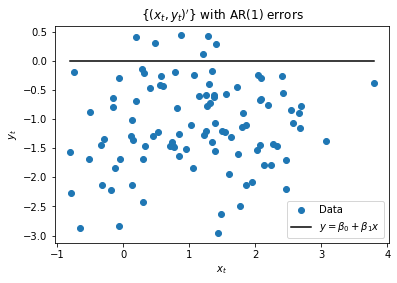

In [ ]:
beta = np.array([0, 0])
x = scipy.stats.norm.rvs(loc=1, scale=1, size=T)
y = beta[0] + beta[1] * x + u
grid = np.array([np.min(x), np.max(x)])
plt.scatter(x, y, label='Data')
plt.plot(grid, beta[0] + beta[1] * grid, color='black', label='$y = \\beta_0 + \\beta_1 x$')
plt.title('$\\{(x_t, y_t)\'\\}$ with AR(1) errors')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.show()

For this reason, $\hat{\beta}_0$ is going to be much worse than in i.i.d. case.

In fact, $V_\beta = \dfrac{\sigma_u^2}{\sigma_x^2} \begin{pmatrix} \frac{1 + \rho}{1 - \rho} \sigma_x^2 + \mu_x^2 & -\mu_x \\ -\mu_x & 1 \end{pmatrix}$.